In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

In [4]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULES_PATH = os.path.join(BASE_PATH, "modules")
TF_PATH = os.path.join(BASE_PATH, "tf_al")
TF_MP_PATH = os.path.join(BASE_PATH, "tf_al_mp")

In [5]:
sys.path.append(MODULES_PATH)
sys.path.append(TF_PATH)
sys.path.append(TF_MP_PATH)

In [16]:
from models import fchollet_cnn, setup_growth, disable_tf_logs
from tf_al import Config
from tf_al_mp.wrapper import MomentPropagation
from tf_al_mp.utils import MP

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [8]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [9]:
num_classes = len(np.unique(y_train))

In [10]:
disable_tf_logs()
setup_growth()
base_model = fchollet_cnn(output=num_classes)

1 Physical GPU's,  1 Logical GPU's


In [11]:
mp_model = MomentPropagation(base_model)
mp_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

In [12]:
mp_model.fit(x_train, y_train, epochs=5, batch_size=50)

Epoch 1/5
1200/1200 [==============================] - 4s 4ms/step - loss: 0.5173 - sparse_categorical_accuracy: 0.8972
Epoch 2/5
1200/1200 [==============================] - 4s 4ms/step - loss: 0.1413 - sparse_categorical_accuracy: 0.9592
Epoch 3/5
1200/1200 [==============================] - 4s 4ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9693
Epoch 4/5
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0901 - sparse_categorical_accuracy: 0.9740
Epoch 5/5
1200/1200 [==============================] - 4s 4ms/step - loss: 0.0793 - sparse_categorical_accuracy: 0.9761


In [13]:
mp_model.evaluate(x_test, y_test)

{'sparse_categorical_crossentropy': 0.12161169,
 'sparse_categorical_accuracy': 0.9883}

# Evaluate Samples

In [17]:
exp, var = mp_model(x_test[:100])
exp_s, var_s = MP.Gaussian_Softmax(exp, var)

In [22]:
def evaluate(prob, real_targets):
    """
        Evaluate accuracy of predictions.
        
        Parameters:
            prob (numpy.ndarray): Probabilities given by estimator. With optional sample dimension.
            real_targets (numpy.ndarray): The real targets
            
        Returns:
            (float) the accuracy of the estimator
    """
    
    if len(prob.shape) == 2:
        return np.mean(np.argmax(prob, axis=-1)==real_targets, axis=0)
    
    return np.mean(np.argmax(np.mean(sampled_datapoints, axis=0), axis=1)==real_targets)

In [100]:
from scipy.stats import norm

exp_shape = list(exp.shape)
#sample_sizes = np.arange(20, 500, 10)
sample_sizes = [1, 5, 10, 100, 500]
acc = []
std = []
mean = []

print(sample_sizes)

for size in sample_sizes:
    final_shape = tuple([size] + exp_shape)
    sampled_datapoints = norm(exp, np.sqrt(var)).rvs(size=final_shape)

    softmax_output = tf.keras.activations.softmax(tf.convert_to_tensor(sampled_datapoints))
    sample_acc = evaluate(softmax_output, y_train[:100])
    mean.append(np.mean(softmax_output, axis=0))
    std.append(np.std(softmax_output, axis=0))
    #acc.append(sample_acc)

[1, 5, 10, 100, 500]


In [101]:
exp_s_norm = np.linalg.norm(exp_s)
mean_scalar = list(map(lambda x: np.diag(np.dot(exp_s, x.T))/(exp_s_norm*np.linalg.norm(x)), mean))

var_s_norm = np.linalg.norm(var_s)
std_scalar = list(map(lambda x: np.diag(np.dot(np.sqrt(var_s), x.T))/(var_s_norm*np.linalg.norm(x)) , std))

/tmp/ipykernel_12297/4101738346.py:5: RuntimeWarning: invalid value encountered in true_divide
  std_scalar = list(map(lambda x: np.diag(np.dot(np.sqrt(var_s), x.T))/(var_s_norm*np.linalg.norm(x)) , std))


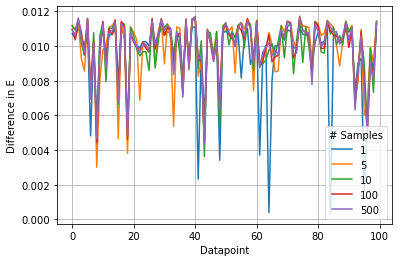

In [102]:
plt.plot(np.vstack(mean_scalar).T, label=sample_sizes)
plt.legend(title="# Samples")
plt.xlabel("Datapoint")
plt.ylabel("Difference in E")
plt.grid()
plt.show()

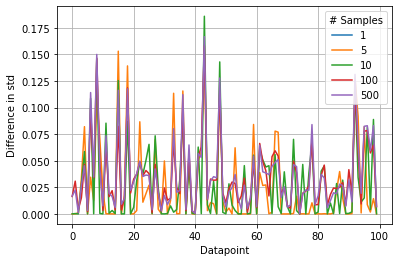

In [103]:
plt.plot(np.vstack(std_scalar).T, label=sample_sizes)
plt.legend(title="# Samples")
plt.xlabel("Datapoint")
plt.ylabel("Difference in std")
plt.grid()
plt.show()

In [104]:
# mean per sample size berechnen
frame_data = {"mean": [], "std": [], "sample_size": []}
for idx in range(len(sample_sizes)):
    sample_mean = mean_scalar[idx]
    sample_std = std_scalar[idx]
    frame_data["sample_size"] += [sample_sizes[idx]]
    frame_data["mean"].append(np.mean(sample_mean))
    frame_data["std"].append(np.mean(sample_mean))


In [105]:
mean_data = pd.DataFrame(frame_data)

In [106]:
mean_data

,mean,std,sample_size
0,0.009505,0.009505,1
1,0.009882,0.009882,5
2,0.009951,0.009951,10
3,0.009992,0.009992,100
4,0.009996,0.009996,500


[Text(0.5, 0, 'Number of samples'), Text(0, 0.5, 'Difference in Mean')]

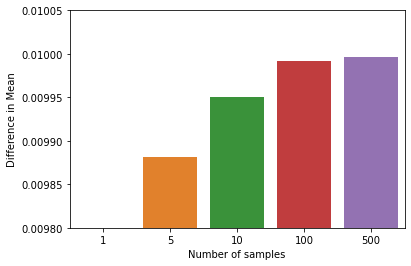

In [107]:
fig = sns.barplot(data=mean_data, x="sample_size", y="mean")
fig.set_ylim(0.0098, 0.01005)
fig.set(xlabel="Number of samples", ylabel="Difference in Mean")